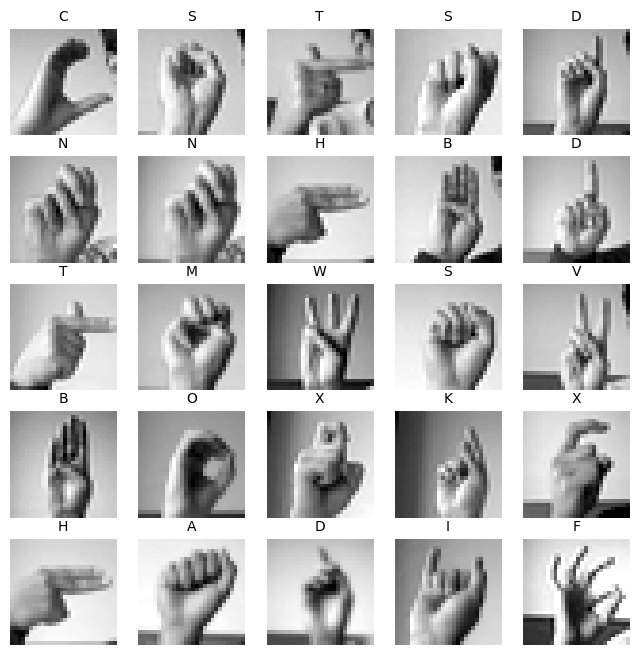

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, RandomTranslation, RandomZoom, RandomRotation, Flatten
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Dense, Dropout
from timeit import default_timer as timer
train = pd.read_csv('./sign_mnist_train.csv')
test = pd.read_csv('./sign_mnist_test.csv')
label_map = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
X_train_full = train.values[:,1:].astype(np.float32())
y_train_full = train.values[:,0]
X_test = test.values[:,1:].astype(np.float32())
y_test = test.values[:,0]
# splitting validation set from the training set using stratified splitting
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=2500)
for train_index, test_index in split.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[test_index]
    y_train, y_val = y_train_full[train_index], y_train_full[test_index]
# visualizing random images from the training set
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
train_len = X_train.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(train_len)
    ax.set_title(label_map[y_train[idx]], size=10)
    ax.axis('off')
    ax.imshow(X_train[idx].reshape((28,28)), cmap='gray');
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
from sklearn.metrics import accuracy_score

models_data = {}

def model_fit_and_print_acc(model):
    start_train = timer()
    model.fit(X_train, y_train)
    end_train = timer()
    start_pred = timer()
    train_pred = model.predict(X_train)
    end_pred = timer()
    train_acc = accuracy_score(train_pred, y_train)
    print("Train accuracy: ", train_acc)
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(test_pred, y_test)
    print("Test accuracy: ", test_acc)
    return [end_train-start_train, end_pred-start_pred, train_acc, test_acc]



In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
models_data['KNN'] = model_fit_and_print_acc(knn)

Train accuracy:  0.9987176918453216
Test accuracy:  0.8119074177356386


In [19]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
models_data['Random Forest'] = model_fit_and_print_acc(forest_clf)

Train accuracy:  1.0
Test accuracy:  0.8112102621305075


In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000)
models_data['Logistic Regression'] = model_fit_and_print_acc(log_reg)

Train accuracy:  1.0
Test accuracy:  0.6872559955382042


In [21]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history['loss'], label="Train loss")
    ax1.plot(history['val_loss'], label="Validation loss")
    ax2.plot(history['accuracy'], label="Train accuracy")
    ax2.plot(history['val_accuracy'], label="Validation accuracy")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);

In [22]:
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_val = X_val.reshape((X_val.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))
image_shape = X_train[0].shape

In [23]:
model = tf.keras.Sequential([
    Input(shape=image_shape),
    RandomTranslation(0.15, 0.15),
    RandomZoom(0.15),
    RandomRotation(0.1),
    Conv2D(8, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(8, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Conv2D(16, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(16, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Conv2D(32, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    Conv2D(32, kernel_size=(3,3), strides=1, padding="same"),
    BatchNormalization(),
    ReLU(),
    MaxPool2D(pool_size=2, strides=2, padding="valid"),
    Flatten(),
    Dense(100),
    Dropout(0.50),
    ReLU(),
    Dense(26, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_translation_1            │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 28, 28, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 50,014 (195.37 KB)

 Trainable params: 49,790 (194.49 KB)

 Non-trainable params: 224 (896.00 B)

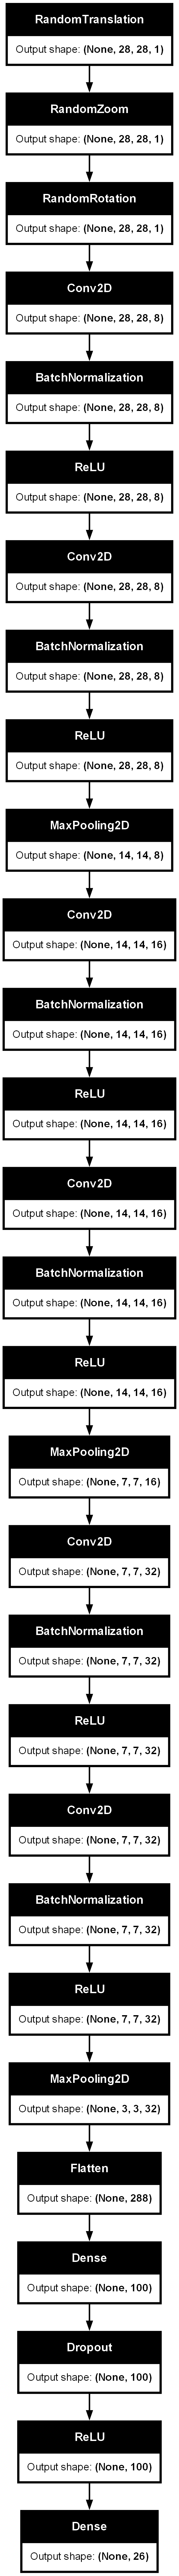

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [25]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005), metrics=["accuracy"])

In [26]:
batch_size = 32
start_train = timer()
history = model.fit(X_train, y_train, epochs=30, batch_size=batch_size, validation_data=(X_val, y_val))
end_train = timer()

Epoch 1/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.1156 - loss: 3.0632 - val_accuracy: 0.5080 - val_loss: 1.5011
Epoch 2/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3562 - loss: 1.9815 - val_accuracy: 0.6820 - val_loss: 0.8773
Epoch 3/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5093 - loss: 1.4417 - val_accuracy: 0.7572 - val_loss: 0.6586
Epoch 4/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6212 - loss: 1.1061 - val_accuracy: 0.8148 - val_loss: 0.4906
Epoch 5/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6845 - loss: 0.9050 - val_accuracy: 0.8932 - val_loss: 0.3360
Epoch 6/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7413 - loss: 0.7470 - val_accuracy: 0.8684 - val_loss: 0.3851
Epoch 7/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7711 - loss: 0.6565 - val_accuracy: 0.8992 - val_loss: 0.2640
Epoch 8/30
780/780 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8071 - loss: 0.5640 - val_acc

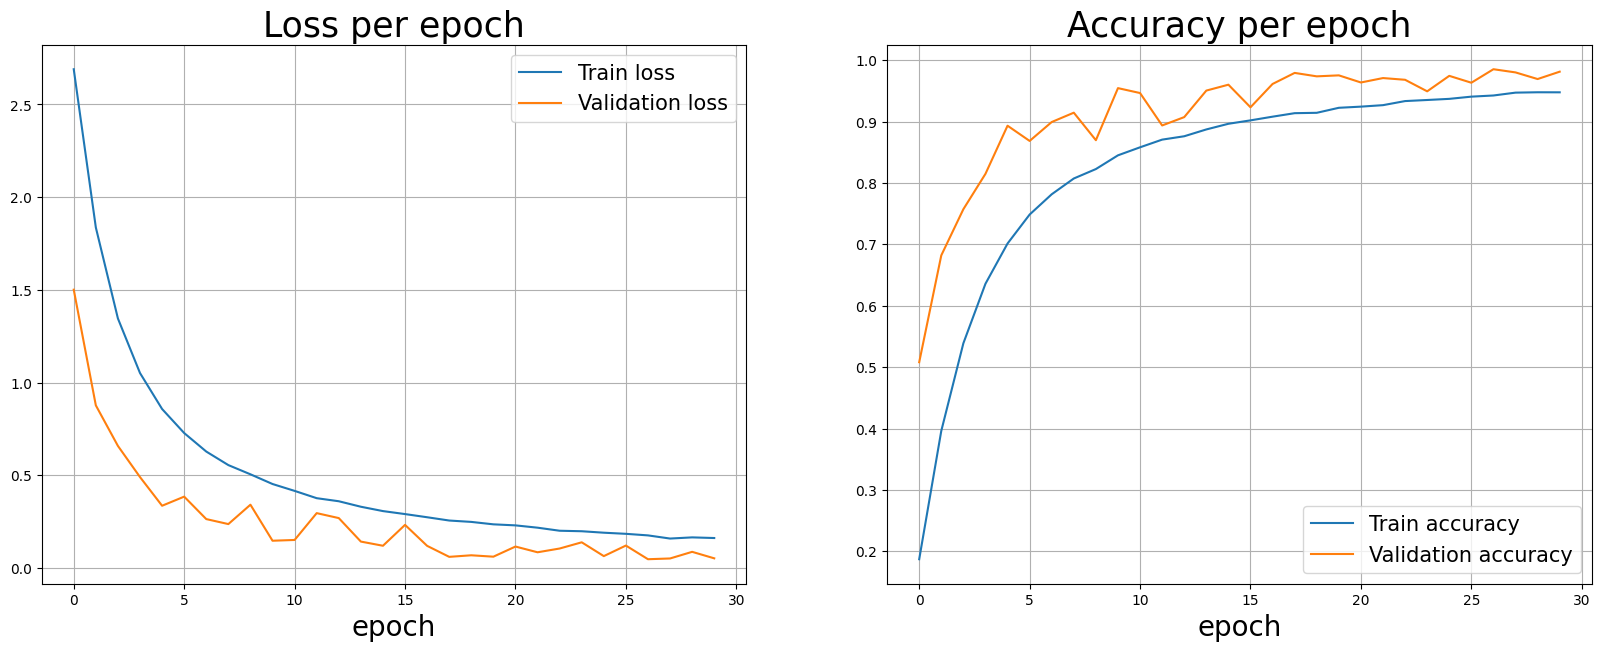

In [27]:
plot_results(history.history)

In [28]:
start_pred = timer()
train_acc = model.evaluate(X_train, y_train)[1]
end_pred = timer()
test_acc = model.evaluate(X_test, y_test)[1]
models_data['CNN'] = [end_train-start_train, end_pred-start_pred, train_acc, test_acc]

780/780 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9838 - loss: 0.0515
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9751 - loss: 0.0888


In [29]:
test_pred = np.argmax(model.predict(X_test), axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision: ", precision_score(y_test, test_pred, average="micro").round(2))
print("Recall: ", recall_score(y_test, test_pred, average="micro").round(2))
print("F1 Score: ", f1_score(y_test, test_pred, average="micro").round(2))

Precision:  0.97
Recall:  0.97
F1 Score:  0.97


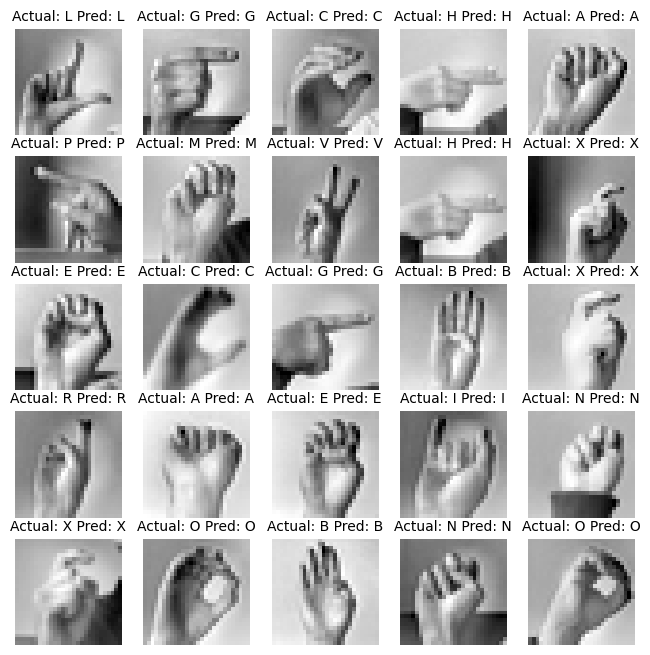

In [31]:
# visualizing predictions of random images from the test set
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(8,8))
test_len = X_test.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(test_len)
    pred = test_pred[idx]
    ax.set_title("Actual: "+label_map[y_test[idx]]+" Pred: "+label_map[pred], size=10)
    ax.axis('off')
    ax.imshow(X_test[idx], cmap='gray');

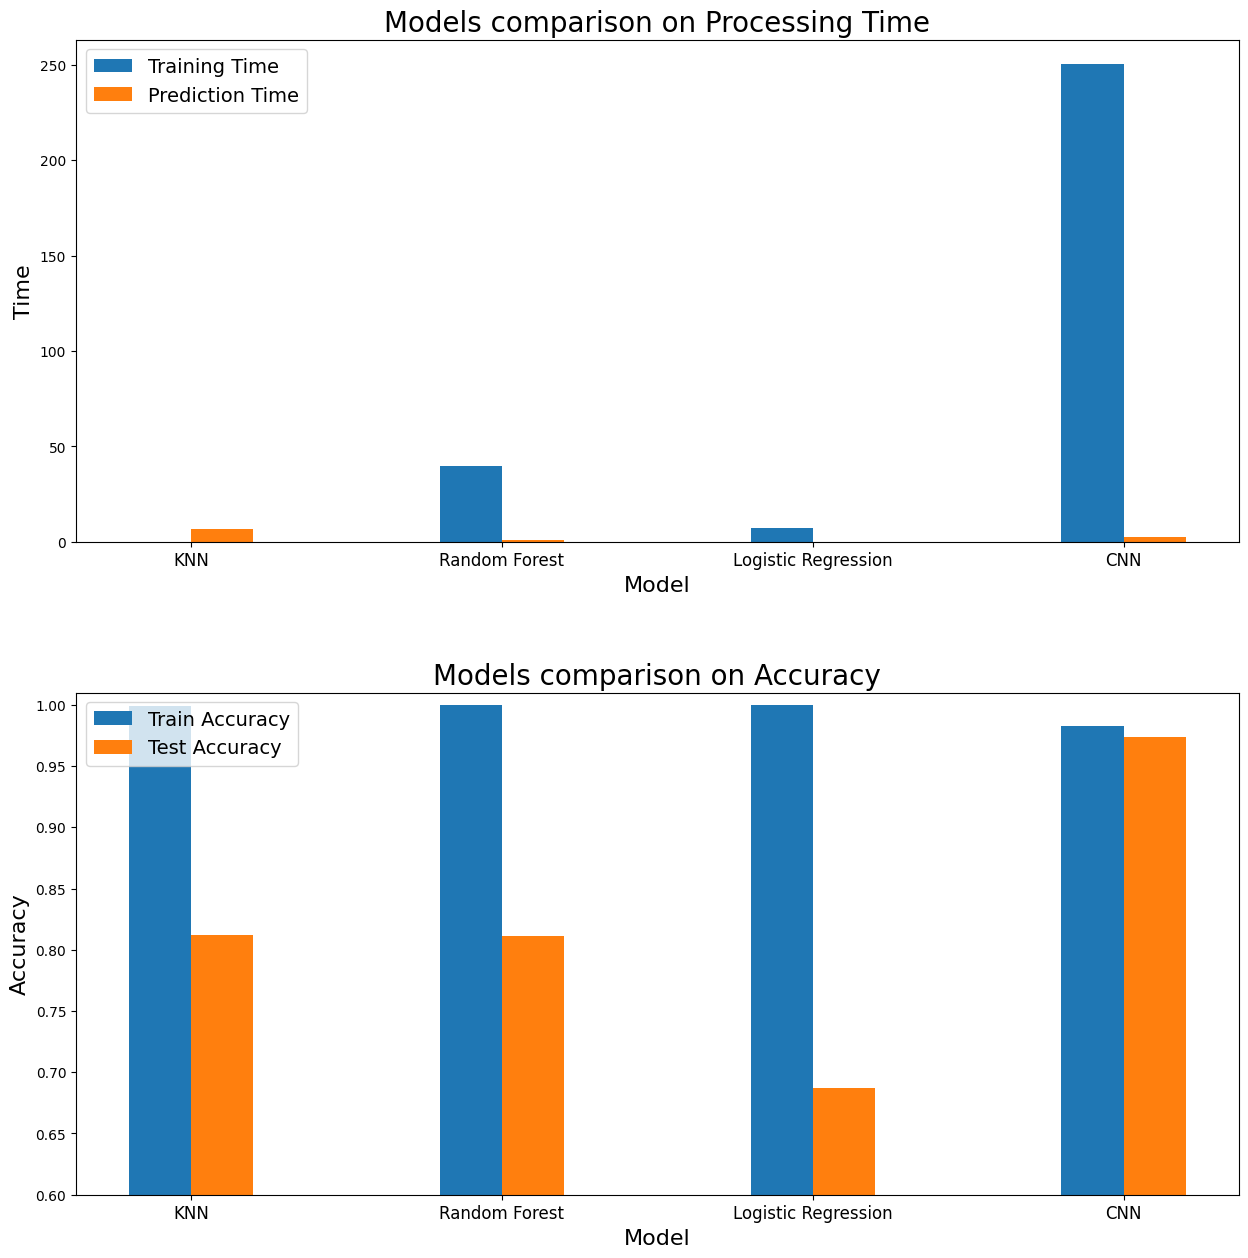

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
fig.subplots_adjust(hspace=0.3)

X = models_data.keys()
X_axis = np.arange(len(X))

ax1.bar(X_axis - 0.1, [value[0] for value in models_data.values()], 0.2, label = 'Training Time');
ax1.bar(X_axis + 0.1, [value[1] for value in models_data.values()], 0.2, label = 'Prediction Time');
ax1.set_xticks(X_axis, X, fontsize=12);
ax1.legend(fontsize=14);
ax1.set_xlabel("Model", fontsize=16)
ax1.set_ylabel("Time", fontsize=16);
ax1.set_title("Models comparison on Processing Time", fontsize=20)

ax2.bar(X_axis - 0.1, [value[2] for value in models_data.values()], 0.2, label = 'Train Accuracy');
ax2.bar(X_axis + 0.1, [value[3] for value in models_data.values()], 0.2, label = 'Test Accuracy');
ax2.set_xticks(X_axis, X, fontsize=12);
ax2.legend(fontsize=14);
ax2.set_xlabel("Model", fontsize=16)
ax2.set_ylabel("Accuracy", fontsize=16)
ax2.set_ylim((0.6, 1.01));
ax2.set_title("Models comparison on Accuracy", fontsize=20);